# 2. Mehrschichtiges feedforward-Netz
Nachfolgend sollen die Methoden `feedForward`, `backPropagation` vervollständigt werden.
Um die Implementierungen zu prüfen, können die Methoden `checkFeedForward` und `checkBackPropagation` verwendet werden.
Anschließend werden verschiedene Architekturen (Layer, Anzahl Neuronen, Aktivierungsfunktionen, Batch-Sizes, Learningrates) manuell ausgetestet werden, um für die Beispiel-Funktionen optimale Ergebnisse zu erzielen. Danach folgt eine Implementierung mit `torch.nn`, `torch.autograd` und `torch.optim` und ein weiterer Test der Architekturen. Abschließend werden alternatvie Optimierungsalgorithmen ausgetestet.

# 2.1 Implementierung Backpropagation

In [10]:
import torch
import math
%matplotlib inline
# Mehrschichtiges Neuronalels Netzwerk
# Eingaben:
#   layers: Anzahl an Neuronen pro Layer
#   activations: verwendete Aktivierungsfunktionen pro Layer
class NeuralNetwork(object):
    def __init__(self, layers = [1, 10, 1], activations=['sigmoid', 'sigmoid']):
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = [] # Shape in Layer-i [Neuronen in i, Neuronen in i+1]
        self.biases = []  # Shape in Layer-i [1, Neuronen in i+1]
        
        # Initialisieren der Gewichte und Bias pro Layer mit Zufallswerten
        for i in range(len(layers)-1):
            self.weights.append(self.initializeWeight(layers[i], layers[i+1], self.activations[i]))
            self.biases.append(self.initializeWeight(1, layers[i+1], self.activations[i]))
    
    def initializeWeight(self, outputDim, inputDim, name):
        if(name == 'sigmoid'):
            return torch.randn(outputDim, inputDim)
        elif(name == 'linear'):
            tensor = torch.empty(outputDim, inputDim)
            torch.nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))
            return tensor
        elif(name == 'relu'):
            return torch.randn(outputDim, inputDim)*math.sqrt(2/inputDim)
        elif(name == 'tanh'):
            return torch.randn(outputDim, inputDim)*math.sqrt(1/inputDim)
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            tensor = torch.empty(outputDim, inputDim)
            torch.nn.init.kaiming_uniform_(tensor, a=math.sqrt(5))
            return tensor
    
    def getActivationFunction(self, name):
        if(name == 'sigmoid'):
            return lambda x : torch.exp(x)/(1+torch.exp(x))
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = torch.clone(x)
                y[y<0] = 0
                return y
            return relu
        elif(name == 'tanh'):
            return lambda x : torch.tanh(x)
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return lambda x: x

    def getDerivitiveActivationFunction(self, name):
        if(name == 'sigmoid'):
            sig = lambda x : torch.exp(x)/(1+torch.exp(x))
            return lambda x :sig(x)*(1-sig(x)) 
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def relu_diff(x):
                y = torch.clone(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return relu_diff
        elif(name == 'tanh'):
            return lambda x : 1 - torch.tanh(x)**2
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return lambda x: 1
    
    def predict(self, X):
        (_, a_s) = self.feedForward(X)
        return a_s[-1]
    
    # Berechnung der Ausgaben
    # Es werden alle Summen vor und nach der Aktivierungsfunktion pro Layer zurückgegeben,
    # damit sie für die Backpropagation benutzt werden künenn
    # Eingaben:
    #   x: Eingabe an den ersten Layer [batch_size, 1]
    # Ausgaben:
    #   z_s: Summen (vor Aktivierungsfunktion) pro Layer, [batch_size, Neuronen in Layer i] 
    #   a_s: Ausgaben pro Layer, [batch_size, Neuronen in Layer i] 
    def feedForward(self, x):
        a = x.clone()
        z_s = []
        a_s = [a] 
        
        # Feedforward der Eingaben
        for w in range(len(self.weights)):
            z_s.append(a.mm(self.weights[w]) + self.biases[w])
            activationFunction = self.getActivationFunction(self.activations[w])
            a_s.append(activationFunction(z_s[-1]))
            a = a_s[-1]

        return (z_s, a_s)
    
    # Backpropagation
    # Zurückverteilen der Deltas an die Gewichte und Biases
    # Eingaben:
    #   z_s: Summen (vor Aktivierungsfunktion) pro Layer, [batch_size, Neuronen in Layer i] 
    #   a_s: Ausgaben pro Layer, [batch_size, Neuronen in Layer i] 
    # Ausgaben:
    #   dw: Ableitungen bezüglich der Gewichte pro Layer, [batch_size, Neuronen in Layer i] 
    #   db: Ableitungen bezüglich der Biases pro Layer, [batch_size, 1] 
    def backPropagation(self,y, z_s, a_s):
            dw = []  # dC/dW
            db = []  # dC/dB
            deltas = [None] * len(self.weights)  # delta = dC/dZ Fehler pro Layer
            # Füllen des Fehlers im letzten Layer anhand der erwarteten Ausgaben des Netzwerks
            deltas[-1] = (y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1])(z_s[-1]))
            
            # Ausführen der Backpropagation
            # Füllen des Fehlers im Layer anhand der bisherigen Deltas
            for k in reversed(range(len(deltas)-1)):
                deltas[k] = deltas[k+1].mm(self.weights[k+1].T)*(self.getDerivitiveActivationFunction(self.activations[k])(z_s[k]))
                                
            batch_size = y.shape[0]
            # Bestimmen der Gewichtsänderung
            db = [torch.ones(1, batch_size).mm(d/float(batch_size)) for d in deltas]
            dw = [a_s[i].T.mm(d)/float(batch_size) for i,d in enumerate(deltas)]

            # Rückgabe der Ableitungen bezüglich der Gewichte und Biases
            return dw, db

    # Aktualisieren der Gewichte und Bias anhand der Ausgabe in mehreren Batches und Epochen
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
            for e in range(epochs): 
                i=0
                while(i<y.shape[0]):
                    x_batch = x[i:i+batch_size]
                    y_batch = y[i:i+batch_size]
                    i = i+batch_size
                    z_s, a_s = self.feedForward(x_batch)
                    dw, db = self.backPropagation(y_batch, z_s, a_s)
                    self.weights = [w+lr*dweight for w,dweight in zip(self.weights, dw)]
                    self.biases = [w+lr*dbias for w,dbias in zip(self.biases, db)]
                    # print("loss = {}".format(torch.norm(a_s[-1]-y_batch)))

            


In [7]:
def createSampleNeuralNetwork():
    nn = NeuralNetwork(layers = [2 , 10, 1], activations=['sigmoid', 'sigmoid'])
    
    # Feste Gewichte und Bias setzen, damit das Ergebnis immer gleich ist.
    nn.weights = [
        torch.tensor([
            [ 0.1397, -0.5724,  0.2194, -3.0984,  0.6770, -0.3220,  1.4311,  0.0931, -0.7618,  0.6987],
            [ 0.7182,  2.8919, -1.9848, -0.2261, -1.1376, -0.0176, -0.2824, -1.6781, -1.1798, -1.5255]
        ]),
        torch.tensor([
            [ 3.0417],
            [-1.1143],
            [-2.2069],
            [-1.1303],
            [ 0.5879],
            [ 0.5013],
            [ 1.1043],
            [ 0.8942],
            [-1.3571],
            [ 0.7487]
        ])
    ]
    
    nn.biases = [
        torch.tensor([
            [ 0.7933,  0.5149, -1.4123,  0.6115,  0.0221, -1.2227,  1.4272, -0.9937, -0.5665, -0.6665]
        ]),
        torch.tensor([
            [-1.6589]]
        )
    ]
    
    return nn

In [8]:
def checkFeedForward():
    nn = createSampleNeuralNetwork()
    
    # Feste Eingabewerte für den Test
    X = torch.tensor([
        [ 0.1397,  0.7182],
        [-0.5724,  2.8919]
    ]).T
    
    # Eingaben mit den Gewichten verarbeiten
    a_s = nn.predict(X)
    
    # Erwartete Ausgabe des letzten Layers
    expected = torch.tensor([
            [0.4855000078678131, 0.7422999739646912]
    ]).T
    
    assert(torch.allclose(expected, a_s, rtol = 1e-04, atol = 1e-04))
    
checkFeedForward()
    

In [12]:
def checkBackPropagation():
    nn = createSampleNeuralNetwork()
    
     # Feste Eingabewerte für den Test
    X = torch.tensor([
        [ 0.1397, -0.5724],
        [ 0.7182,  2.8919]
    ])

    
    Y = torch.tensor([
        [0.8000],
        [0.1000]
    ])
    
    # Eingaben mit den Gewichten verarbeiten
    z_s, a_s = nn.feedForward(X)
    
    # Deltas bestimmen
    dw, db = nn.backPropagation(Y, z_s, a_s)
    
    dwExpected = [
        torch.tensor([
            [-0.0022, -0.0011, -0.0029,  0.0027, -0.0007, -0.0028, -0.0059,  0.0011, -0.0012,  0.0007],
            [-0.0415,  0.0044,  0.0126,  0.0233, -0.0086, -0.0152, -0.0298, -0.0055, 0.0102, -0.0055]
        ]),
        torch.tensor([
            [-0.0349],
            [-0.0525],
            [ 0.0172],
            [ 0.0169],
            [ 0.0232],
            [-0.0025],
            [-0.0178],
            [ 0.0193],
            [ 0.0190],
            [ 0.0220]
        ])   
    ]
    
    dbExpected = [
        torch.tensor([
            [ 0.0200, -0.0077, -0.0212, -0.0049,  0.0030, -0.0012, -0.0039,  0.0086, -0.0124,  0.0067]
        ]),
        torch.tensor([
            [-0.0222]
        ])
    ]
    
    
    assert(torch.allclose(dw[0], dwExpected[0], rtol = 1e-04, atol = 1e-04))
    assert(torch.allclose(dw[1], dwExpected[1], rtol = 1e-04, atol = 1e-04))
    assert(torch.allclose(db[0], dbExpected[0], rtol = 1e-04, atol = 1e-04))    
    assert(torch.allclose(db[1], dbExpected[1], rtol = 1e-04, atol = 1e-04))
    
checkBackPropagation()

# 2.2 Optimierung der Hyperparameter

Loss: 0.8313775062561035


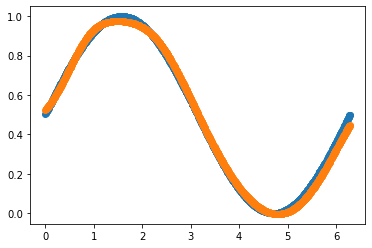

Loss: 0.0011249841190874577


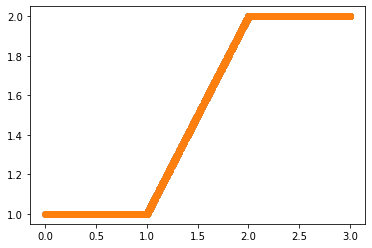

Loss: 3.150113821029663


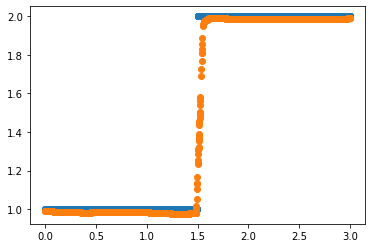

Loss: 0.35043856501579285


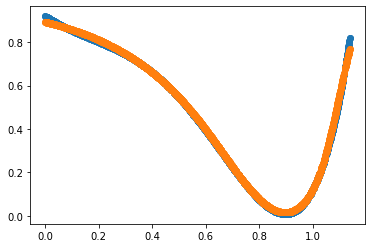

In [13]:
import matplotlib.pyplot as plt

def sinus(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    sinus_nn = NeuralNetwork(layers=hidden_layers, activations=activation_function)

    sinus_X = 2*math.pi*torch.rand(2000).reshape(-1, 1)
    sinus_y = (torch.sin(sinus_X) + 1) / 2

    sinus_nn.train(sinus_X, sinus_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    sinus_a_s = sinus_nn.predict(sinus_X)
    print(f"Loss: {torch.norm(sinus_a_s-sinus_y)}")

    plt.scatter(sinus_X.flatten(), sinus_y.flatten())
    plt.scatter(sinus_X.flatten(), sinus_a_s.flatten())
    plt.show()

def linear1(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear1_nn = NeuralNetwork(layers=hidden_layers, activations=activation_function)

    nlinear1_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear1_y = torch.clone(nlinear1_X)
    nlinear1_y[nlinear1_y>=2] = 2
    nlinear1_y[nlinear1_y<1] = 1

    nlinear1_nn.train(nlinear1_X, nlinear1_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear1_a_s = nlinear1_nn.predict(nlinear1_X)
    print(f"Loss: {torch.norm(nlinear1_a_s-nlinear1_y)}")
    
    plt.scatter(nlinear1_X.flatten(), nlinear1_y.flatten())
    plt.scatter(nlinear1_X.flatten(), nlinear1_a_s.flatten())
    plt.show()

def linear2(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear2_nn = NeuralNetwork(layers=hidden_layers, activations=activation_function)
    
    nlinear2_X = 3*torch.rand(2000).reshape(-1, 1)
    nlinear2_y = torch.clone(nlinear2_X)
    nlinear2_y[nlinear2_y>=1.5] = 2
    nlinear2_y[nlinear2_y<1.5] = 1

    nlinear2_nn.train(nlinear2_X, nlinear2_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear2_a_s = nlinear2_nn.predict(nlinear2_X)
    print(f"Loss: {torch.norm(nlinear2_a_s-nlinear2_y)}")
    
    plt.scatter(nlinear2_X.flatten(), nlinear2_y.flatten())
    plt.scatter(nlinear2_X.flatten(), nlinear2_a_s.flatten())
    plt.show()

def linear3(activation_function, batchsize, epochsize, learning_rate, hidden_layers):
    nlinear3_nn = NeuralNetwork(layers=hidden_layers, activations=activation_function)

    nlinear3_X = 1.14*torch.rand(2000).reshape(-1, 1)
    nlinear3_y = (10*nlinear3_X**5 - 8*nlinear3_X**4 - 6*nlinear3_X**3 + 4*nlinear3_X**2 - 2*nlinear3_X + 2.3) / 2.5

    nlinear3_nn.train(nlinear3_X, nlinear3_y, batch_size=batchsize, epochs=epochsize, lr = learning_rate)
    nlinear3_a_s = nlinear3_nn.predict(nlinear3_X)
    print(f"Loss: {torch.norm(nlinear3_a_s-nlinear3_y)}")
    
    plt.scatter(nlinear3_X.flatten(), nlinear3_y.flatten())
    plt.scatter(nlinear3_X.flatten(), nlinear3_a_s.flatten())
    plt.show()

torch.manual_seed(1234)
sinus(activation_function=["tanh", "tanh", "tanh"], batchsize=10, epochsize=200, learning_rate=0.3, hidden_layers=[1, 10, 10, 1])
linear1(activation_function=["relu", "linear"], batchsize=10, epochsize=100, learning_rate=0.1, hidden_layers=[1, 10, 1])
linear2(activation_function=["linear", "relu", "relu", "linear"], batchsize=10, epochsize=200, learning_rate=0.1, hidden_layers=[1, 10, 10, 10, 1])
linear3(activation_function=["linear", "tanh", "tanh", "tanh"], batchsize=10, epochsize=200, learning_rate=0.3, hidden_layers=[1, 10, 10, 10, 1])

# 2.3 Implementierung Backpropagation mit Autograd und Layern

In [53]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline
# Mehrschichtiges Neuronalels Netzwerk
# Eingaben:
#   layers: Anzahl an Neuronen pro Layer
#   activations: verwendete Aktivierungsfunktionen pro Layer
class NeuralNetworkTorch(nn.Module):
    def __init__(self, layers = [1, 10, 1], activations=['sigmoid', 'sigmoid']):
        super(NeuralNetworkTorch, self).__init__()
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.torchLayers = []
        
        # Initialisieren der Gewichte und Bias pro Layer mit Zufallswerten
        for i in range(len(layers)-1):
            a = nn.Linear(layers[i], layers[i+1])
            self.torchLayers.append(a)
            self.add_module('layerLin' + str(i), a)
            if activations[i] != 'linear':
                b = self.getActivationFunction(activations[i])
                self.torchLayers.append(b)                
                self.add_module('layer' + str(i), b)
    
    def getActivationFunction(self, name):
        if(name == 'sigmoid'):
            return nn.Sigmoid()
        elif(name == 'linear'):
            return nn.Linear()
        elif(name == 'relu'):
            return nn.ReLU()
        elif(name == 'tanh'):
            return nn.Tanh()
        else:
            print('Unbekannte Aktivierungsfunktion. linear wird verwendet')
            return nn.Linear()
        
    def predict(self, X):
        return self.feedForward(X).detach()
    
    # Berechnung der Ausgaben
    # Es werden alle Summen vor und nach der Aktivierungsfunktion pro Layer zurückgegeben,
    # damit sie für die Backpropagation benutzt werden künenn
    # Eingaben:
    #   x: Eingabe an den ersten Layer
    # Ausgaben:
    #   a: Ausgabe des letzten Layers
    def feedForward(self, x):
        a = x.clone()

        # Feedforward                
        for i in range(len(self.torchLayers)):
            a = self.torchLayers[i](a)
        return a

    # Aktualisieren der Gewichte und Bias anhand der Ausgabe in mehreren Batches und Epochen
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
        criterion = torch.nn.MSELoss(reduction="mean")
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        a_s = []
        for e in range(epochs): 
            # print("Epoche",e+1,"von",epochs)
            i=0
            while(i<len(y)):
                x_batch = Variable(x[i:i+batch_size])
                y_batch = Variable(y[i:i+batch_size])
                i = i+batch_size

                optimizer.zero_grad()

                a_s.append(self.feedForward(x_batch))

                loss = criterion(a_s[-1], y_batch)

                loss.backward()
                optimizer.step()

NeuralNetworkTorch(
  (layerLin0): Linear(in_features=1, out_features=10, bias=True)
  (layerLin1): Linear(in_features=10, out_features=10, bias=True)
  (layer1): Tanh()
  (layerLin2): Linear(in_features=10, out_features=10, bias=True)
  (layer2): Tanh()
  (layerLin3): Linear(in_features=10, out_features=1, bias=True)
  (layer3): Tanh()
)
Loss: 0.2815934717655182


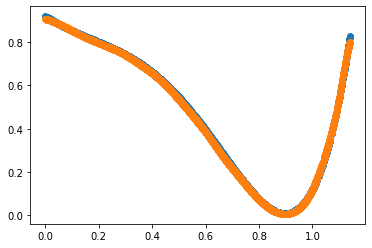

1234


In [42]:
import matplotlib.pyplot as plt
nlinear_nn = NeuralNetworkTorch(activations=["linear", "tanh", "tanh", "tanh"], layers=[1, 10, 10, 10, 1])

nlinear_X = 1.14*torch.rand(2000).reshape(-1, 1)
nlinear_y = (10*nlinear_X**5 - 8*nlinear_X**4 - 6*nlinear_X**3 + 4*nlinear_X**2 - 2*nlinear_X + 2.3) / 2.5

print(nlinear_nn)

nlinear_nn.train(nlinear_X, nlinear_y, batch_size=10, epochs=200, lr=0.01)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

print(f"Loss: {torch.norm(nlinear_a_s-nlinear_y)}")

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

print(torch.initial_seed())

Loss: 4.800174236297607


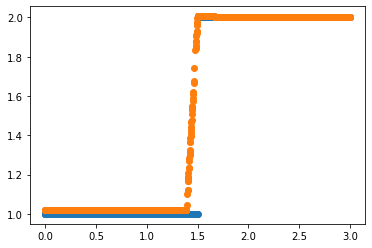

In [54]:
import matplotlib.pyplot as plt
nlinear_nn = NeuralNetworkTorch(layers=[1,10,10,10,1],activations=["relu","relu","relu","relu"])

nlinear_X = 3*torch.rand(2000).reshape(-1, 1)
nlinear_y = torch.clone(nlinear_X)
nlinear_y[nlinear_y>=1.5] = 2
nlinear_y[nlinear_y<1.5] = 1

nlinear_nn.train(nlinear_X, nlinear_y)
nlinear_a_s = nlinear_nn.predict(nlinear_X)

print(f"Loss: {torch.norm(nlinear_a_s-nlinear_y)}")

plt.scatter(nlinear_X.flatten(), nlinear_y.flatten())
plt.scatter(nlinear_X.flatten(), nlinear_a_s.flatten())
plt.show()

# 2.4 Alternative Optimierungsalgorithmen

In [ ]:
# Siehe PDF Dokument "Auswertung.pdf"